In [1]:
import io

import numpy as np
import ee
import cv2

In [2]:
# get test data

PROJECT_ID='dgena-ee-training' #@param {type:"string"}

ee.Authenticate()
ee.Initialize(project=PROJECT_ID)

In [3]:
def get_image_patch(image, center, size, scale=None):
  # Make a projection to discover the scale in degrees.
  proj = image.projection().getInfo()

  # Get scales out of the transform.
  scale_x = proj['transform'][0]
  scale_y = -proj['transform'][4]

  if scale is not None:
    scale_x = scale
    scale_y = scale

  # Transform coordinates from lon/lat to local coordinate system
  center = ee.Geometry.Point(center)
  center = center.transform(proj['crs']).getInfo()

  # Define request for computePixels
  request = {
      'expression': image,
      'fileFormat': 'npy',
      'bandIds': ['R', 'G', 'B'],
      'grid': {
          'dimensions': {
              'width': size,
              'height': size
          },
          'affineTransform': {
              'scaleX': scale_x,
              'shearX': 0,
              'translateX': center['coordinates'][0],
              'shearY': 0,
              'scaleY': scale_y,
              'translateY': center['coordinates'][1]
          },
          'crsCode': proj['crs'],
      }
  }

  v = ee.data.computePixels(request)
  v = np.load(io.BytesIO(v))
  v = np.dstack([v['R'], v['G'], v['B']])

  return v

In [4]:
# initialize vision (image to text) model
import vertexai
from vertexai.preview.vision_models import Image, ImageTextModel

def print_caption(input_file):

  vertexai.init(project=PROJECT_ID, location="us-central1")

  MODEL_ID = "imagetext@001" # @param {type:"string"}
  model = ImageTextModel.from_pretrained("imagetext@001") # PaLI
  source_img = Image.load_from_file(location=input_file)

  captions = model.get_captions(
      image=source_img,
      # Optional parameters
      language="en",
      number_of_results=1,
  )

  print(captions)

In [68]:
# initialize a smarter model
from vertexai.generative_models import GenerativeModel, GenerationConfig

MODEL_ID = "gemini-2.0-flash-exp" # @param {type:"string"}
vertexai.init(project=PROJECT_ID, location="us-central1")

model = GenerativeModel(MODEL_ID)

# Set model parameters
generation_config = GenerationConfig(
    temperature=0.2,
    top_p=1.0,
    top_k=32,
    candidate_count=1,
    max_output_tokens=8192,
)

def print_answer(image_file, prompt):
  contents = [image_file, prompt]
  response = model.generate_content(contents, generation_config=generation_config)

  print(response.text)

array([[[141, 134, 100],
        [148, 143, 112],
        [157, 155, 125],
        ...,
        [215, 215, 214],
        [217, 217, 215],
        [219, 219, 217]],

       [[142, 140, 100],
        [148, 145, 111],
        [154, 152, 122],
        ...,
        [214, 213, 212],
        [214, 214, 213],
        [216, 216, 214]],

       [[144, 145, 100],
        [148, 148, 109],
        [153, 151, 119],
        ...,
        [212, 213, 211],
        [213, 213, 211],
        [214, 214, 212]],

       ...,

       [[190, 191, 187],
        [190, 191, 188],
        [188, 191, 188],
        ...,
        [182, 180, 164],
        [181, 179, 164],
        [181, 179, 164]],

       [[190, 191, 187],
        [190, 191, 188],
        [189, 191, 188],
        ...,
        [188, 188, 180],
        [187, 187, 180],
        [187, 187, 180]],

       [[190, 191, 187],
        [190, 191, 188],
        [189, 191, 188],
        ...,
        [190, 192, 188],
        [189, 191, 188],
        [189, 191, 187]]], dtype=uint8)
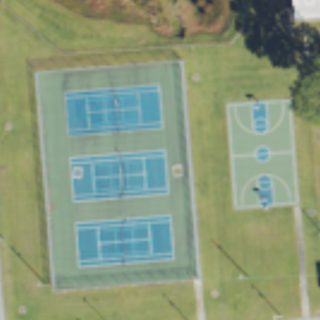

In [84]:
# https://code.earthengine.google.com/b12ec447360ff8300ddae52086d2d6da

coords = [-77.35704518094273, 34.70350144108098]

image = ee.ImageCollection("USDA/NAIP/DOQQ").filterDate('2022', '2024').filterBounds(ee.Geometry.Point(coords)).first().resample('bicubic')

size = 320

patch = get_image_patch(image, coords, size, 0.25)
patch = patch[::-1, :, :].copy()

cv2.imwrite('patch_test1.png', patch[:, :, ::-1])

patch

In [85]:
# good
print_caption('patch_test1.png')

['an aerial view of three tennis courts and a basketball court']


In [86]:
# bad
print_answer('patch_test1.png', 'What do you see in this aerial image?')

Okay, I've analyzed the aerial image you sent (patch_test1.png). Here's what I see:

**Overall Impression:**

The image appears to be an aerial view of a **primarily agricultural area**. It's a patchwork of fields with varying colors and textures, suggesting different crops or stages of growth.

**Specific Details:**

*   **Fields:** The dominant feature is the presence of numerous rectangular and irregularly shaped fields. These fields are the main focus of the image.
*   **Color Variation:** There's a noticeable variation in color across the fields. Some are a vibrant green, likely indicating healthy, growing crops. Others are lighter, possibly tan or brown, which could suggest harvested fields, fallow land, or different types of vegetation. There are also some darker patches which could be soil or different crops.
*   **Field Boundaries:** The fields are clearly delineated by lines, which could be roads, paths, or natural boundaries like hedgerows or drainage ditches.
*   **Texture:

array([[[184, 177, 171],
        [184, 177, 171],
        [180, 173, 165],
        ...,
        [ 82,  96,  63],
        [ 93, 105,  67],
        [110, 122,  84]],

       [[185, 178, 172],
        [182, 175, 169],
        [181, 174, 166],
        ...,
        [ 96, 105,  74],
        [110, 120,  86],
        [130, 140, 106]],

       [[184, 177, 171],
        [179, 172, 166],
        [183, 176, 168],
        ...,
        [117, 121,  98],
        [127, 132, 112],
        [133, 137, 122]],

       ...,

       [[ 26,  31,  27],
        [ 22,  28,  24],
        [ 16,  23,  16],
        ...,
        [145, 132,  97],
        [147, 134,  99],
        [126, 117,  78]],

       [[ 13,  19,  15],
        [ 26,  36,  28],
        [ 21,  28,  20],
        ...,
        [140, 126,  91],
        [139, 124,  85],
        [132, 119,  77]],

       [[ 22,  31,  26],
        [ 21,  31,  23],
        [ 15,  25,  17],
        ...,
        [129, 113,  77],
        [139, 122,  79],
        [148, 131,  88]]], dtype=uint8)
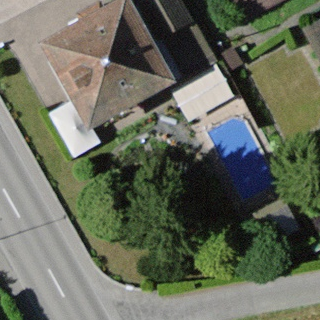

In [87]:
coords = [7.8975600621706965, 47.308244883568]

image = ee.ImageCollection("Switzerland/SWISSIMAGE/orthos/10cm").filterBounds(ee.Geometry.Point(coords)).first()

size = 320

patch = get_image_patch(image, coords, size)
patch = patch[::-1, :, :].copy()

cv2.imwrite('patch_test2.png', patch[:, :, ::-1])

patch

In [88]:
print_caption('patch_test2.png')

['an aerial view of a house with a swimming pool']


In [89]:
print_answer('patch_test2.png', 'How many chimneys are on the roof of this building?')

Based on the image you sent, there are **two** chimneys visible on the roof of the building.


array([[[133, 146,  99],
        [129, 145,  97],
        [123, 142,  92],
        ...,
        [ 52,  60,  62],
        [ 53,  61,  61],
        [ 54,  62,  59]],

       [[130, 144,  95],
        [126, 143,  94],
        [121, 141,  91],
        ...,
        [ 51,  59,  60],
        [ 50,  57,  59],
        [ 48,  55,  57]],

       [[128, 143,  92],
        [125, 142,  91],
        [121, 141,  90],
        ...,
        [ 49,  57,  59],
        [ 47,  54,  57],
        [ 44,  51,  55]],

       ...,

       [[148, 154,  98],
        [148, 154,  98],
        [148, 155,  98],
        ...,
        [141, 145,  93],
        [139, 143,  91],
        [137, 141,  88]],

       [[146, 153,  98],
        [145, 154,  97],
        [145, 154,  97],
        ...,
        [142, 145,  94],
        [140, 143,  92],
        [137, 141,  89]],

       [[144, 152,  97],
        [143, 152,  96],
        [144, 152,  96],
        ...,
        [144, 147,  96],
        [141, 144,  93],
        [137, 141,  90]]], dtype=uint8)
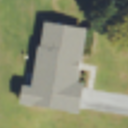

In [90]:
coords = [-77.35179341569157, 34.70511797290014]

image = ee.ImageCollection("USDA/NAIP/DOQQ").filterDate('2022', '2024').filterBounds(ee.Geometry.Point(coords)).first().resample('bicubic')

size = 128

patch = get_image_patch(image, coords, size, 0.25)
patch = patch[::-1, :, :].copy()

cv2.imwrite('patch_test3.png', patch[:, :, ::-1])

patch

In [91]:
print_caption('patch_test3.png')

['an aerial view of a house with a shadow on the ground']


In [97]:
# good - bad - good - bad, results seem to be unstable
print_answer('patch_test3.png', 'Does the tree in the image significantly overlaps with the roof of the building?')

Based on the image you sent, **patch_test3.png**, the tree does **not** significantly overlap with the roof of the building. 

While there are some branches that appear to be close to the roofline, they don't seem to be directly on top of or heavily intertwined with the roof. There's a clear separation between the tree's foliage and the building's roof.

Therefore, the answer is **no**, the tree does not significantly overlap with the roof.



array([[[135, 149,  96],
        [134, 149,  95],
        [132, 148,  94],
        ...,
        [140, 145,  84],
        [142, 148,  83],
        [145, 150,  85]],

       [[136, 148,  98],
        [135, 148,  96],
        [133, 147,  94],
        ...,
        [142, 149,  86],
        [140, 148,  85],
        [141, 147,  86]],

       [[137, 149,  99],
        [136, 148,  97],
        [135, 148,  96],
        ...,
        [143, 151,  88],
        [140, 147,  86],
        [140, 144,  86]],

       ...,

       [[156, 157, 124],
        [154, 157, 122],
        [154, 158, 120],
        ...,
        [190, 190, 184],
        [191, 191, 184],
        [191, 191, 184]],

       [[157, 159, 122],
        [157, 159, 122],
        [157, 160, 121],
        ...,
        [190, 191, 185],
        [191, 191, 185],
        [191, 191, 185]],

       [[162, 164, 128],
        [164, 165, 130],
        [166, 167, 131],
        ...,
        [190, 191, 186],
        [191, 192, 186],
        [191, 192, 187]]], dtype=uint8)
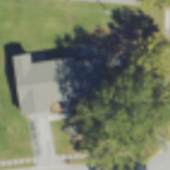

In [98]:
coords = [-77.35079908301183, 34.70400309272154]

image = ee.ImageCollection("USDA/NAIP/DOQQ").filterDate('2022', '2024').filterBounds(ee.Geometry.Point(coords)).first().resample('bicubic')

size = 170

patch = get_image_patch(image, coords, size, 0.25)
patch = patch[::-1, :, :].copy()

cv2.imwrite('patch_test4.png', patch[:, :, ::-1])

patch

In [99]:
print_caption('patch_test4.png')

['an aerial view of a house with a tree in front of it']


In [100]:
print_answer('patch_test4.png', 'Does the tree in the image significantly overlaps with the roof of the building?')

Based on the image you sent, **yes, the tree does significantly overlap with the roof of the building.** 

The branches and foliage of the tree extend over a considerable portion of the roof, creating a clear overlap.

